<a href="https://colab.research.google.com/github/rj7shakya/mlprojects/blob/master/Taxi_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls '/content/drive/My Drive/ml_data'

yellow_tripdata_2020-01.csv


In [10]:
!pip3 install graphviz
!pip3 install dask
!pip3 install toolz
!pip3 install cloudpickle
!pip3 install folium
!pip3 install xgboost
!pip install 'fsspec>=0.3.3'
!pip3 install gpxpy

     |████████████████████████████████| 112kB 6.7MB/s 
  Created wheel for gpxpy: filename=gpxpy-1.4.2-cp36-none-any.whl size=42545 sha256=df8bb6f302fa553795a6723bb7fd5d196d4d1597ea9c06c3a357285b5c1acf37
  Stored in directory: /root/.cache/pip/wheels/d9/df/ed/b52985999b3967fa0ef8de22b3dc8ad3494ce3380d5328dd0f
Successfully built gpxpy


In [11]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import folium
import datetime
import time
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
import gpxpy.geo

from sklearn.cluster import MiniBatchKMeans,KMeans
import math
import pickle
import os

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [32]:
# data -- new york yellow taxi data

month = dd.read_csv('/content/drive/My Drive/ml_data/yellow_tripdata_2020-01.csv',dtype={'RatecodeID': 'float64',
       'VendorID': 'float64',
       'passenger_count': 'float64',
       'payment_type': 'float64'})
month.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge'],
      dtype='object')

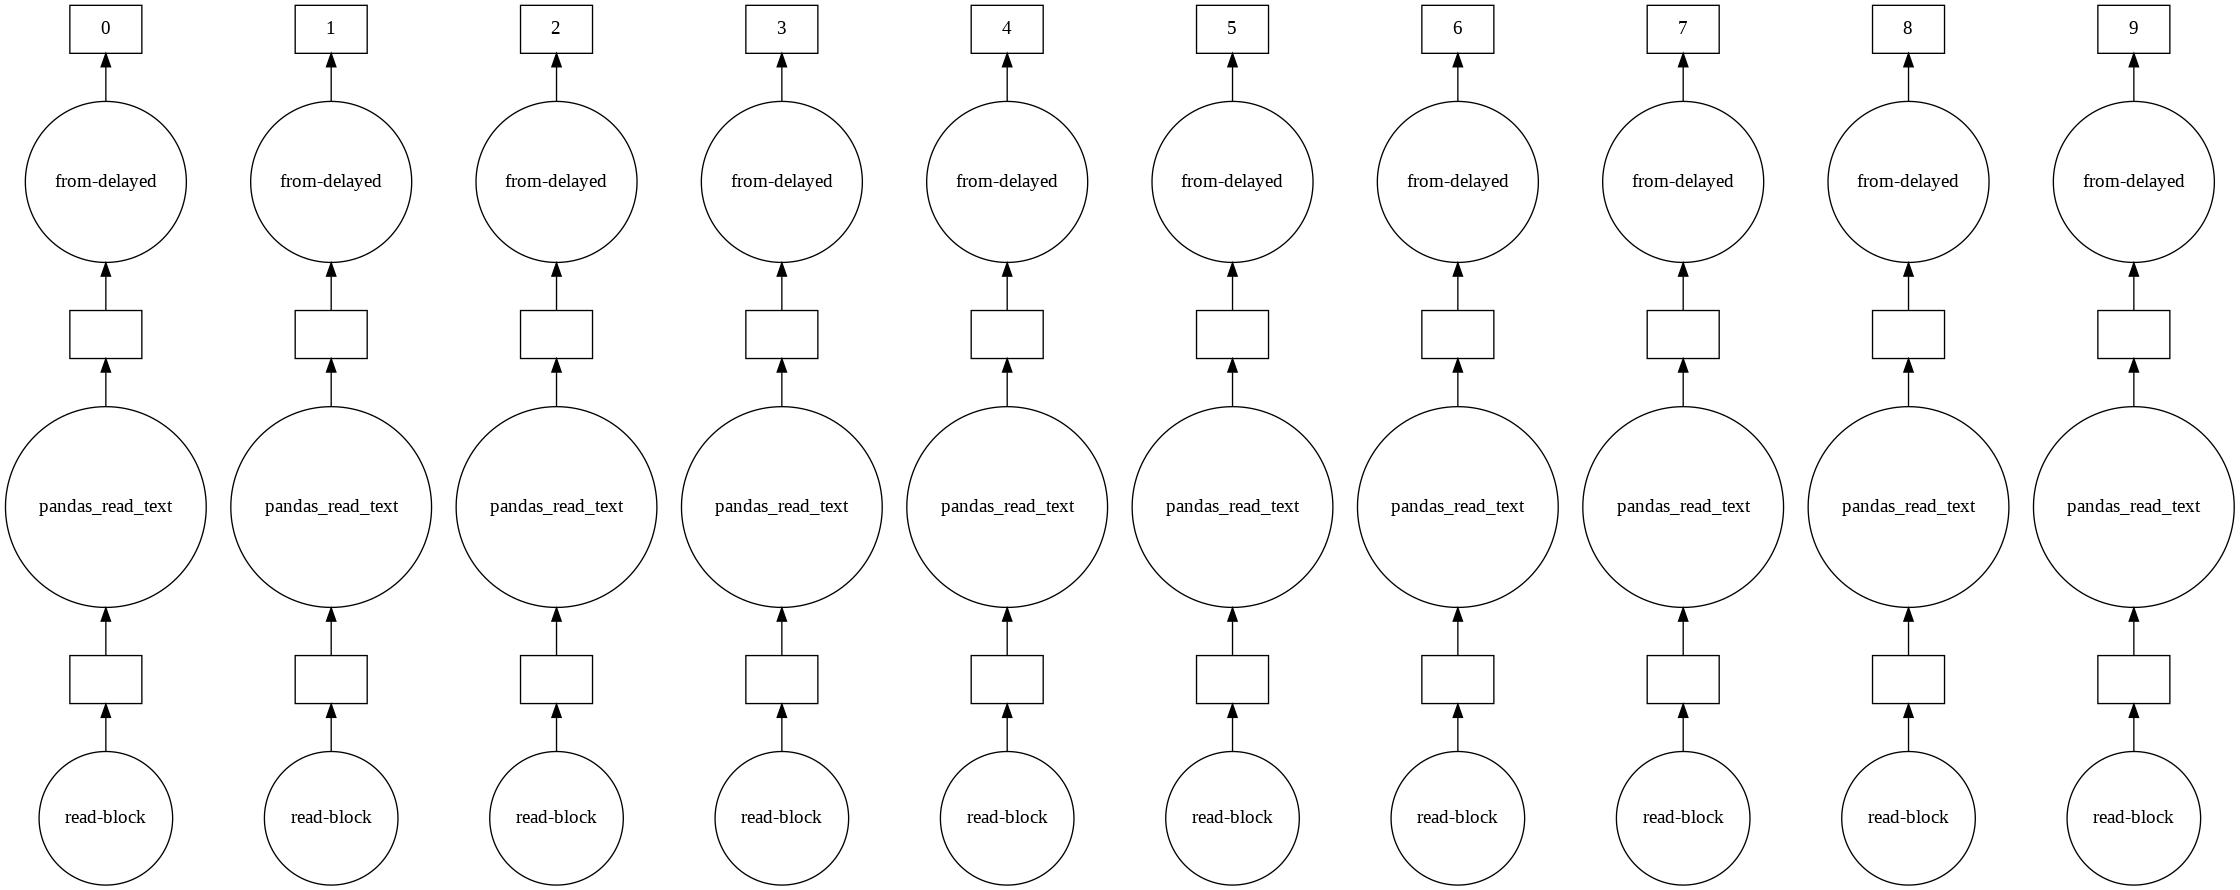

In [33]:
month.visualize()

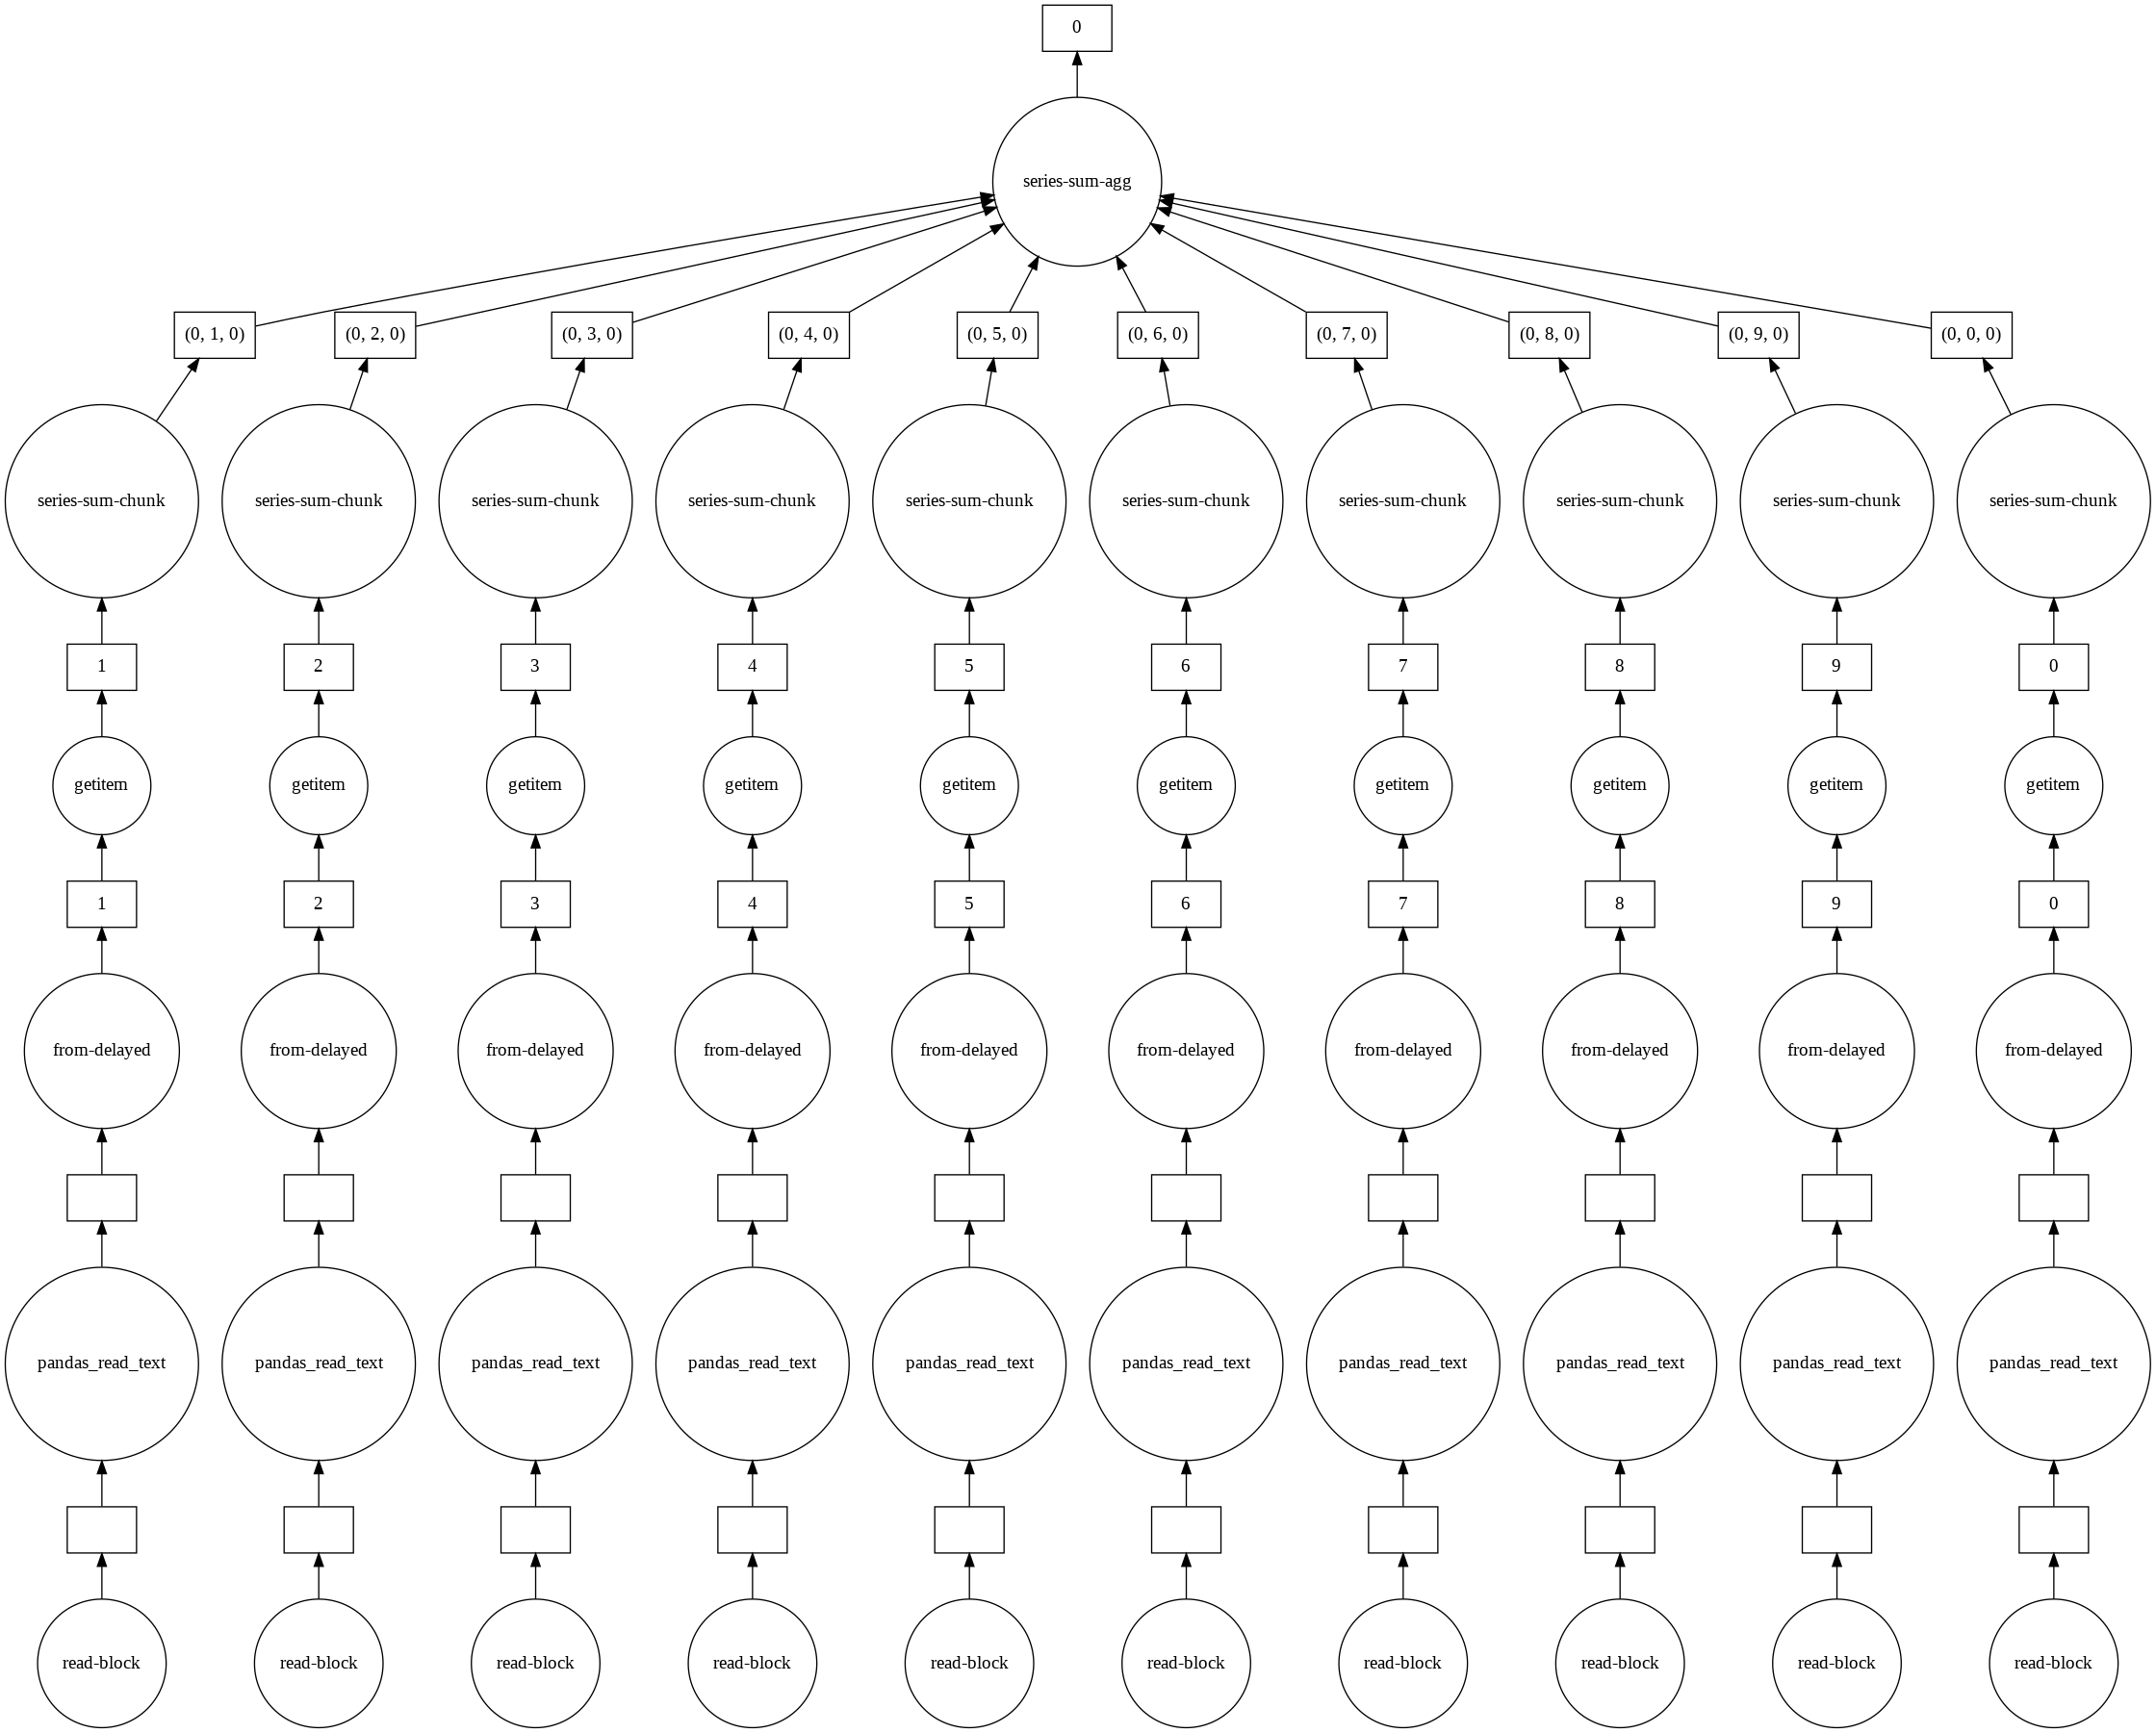

In [34]:
month.fare_amount.sum().visualize()

## Features in the dataset:
<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

		
</table>

**ml problem formulation**
- time series forecasting & regression

**performance metrics**
- mean absolute percentage error
- mean squared error


In [35]:
# data cleaning
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


In [36]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(month)

In [37]:
# the skewed box plot shows us the presence of outliers 
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

<IPython.core.display.Javascript object>

In [38]:
frame_with_durations.head()

,passenger_count,trip_distance,total_amount,trip_times,pickup_times,Speed
0,1.0,1.2,11.27,4.800000,1.577838e+09,15.000000
1,1.0,1.2,12.30,7.416667,1.577839e+09,9.707865
2,1.0,0.6,10.80,6.183333,1.577840e+09,5.822102
3,1.0,0.8,8.16,4.850000,1.577840e+09,9.896907
4,1.0,0.0,4.80,2.300000,1.577837e+09,0.000000
